In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/home/resisistancerow_909/image-to-tex-OCR/Jupyter_Notebooks
Current path:/home/resisistancerow_909/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
import cv2

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.is_available()

True

In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,
                       max_width = 700,


                 batch_size = 64,
                num_workers = 8,
                data_on_gpu = True,
                )


# Generates DataFrame and vocabulary, tokezniers etc
dataset.prepare_data()

# prepeares the dataloaders with transformations and splits train/val
dataset.setup(stage = 'fit')

Train/Val Data is ready for Model loading.


In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    "\nTrain-Dataset size:", len(dataset.data_train),
    "\nValidation-Dataset size:", len(dataset.data_val),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Train-Dataset size: 223035 
Validation-Dataset size: 224 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
# Initiate the model
model = ResNetTransformer(dataset=dataset).to(dev)

/home/resisistancerow_909/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/resisistancerow_909/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Load model here or woth lighithng using checkpoint.

#model.load_state_dict(torch.load(("Models_Parameters_Log/Printed1_2D600_350.pth"), map_location=torch.device(dev)))


In [7]:
%load_ext tensorboard 
%tensorboard --logdir Models_Parameters_Log/

In [8]:
logger = TensorBoardLogger("Models_Parameters_Log", name="2D128_1920_NORM_WHITE")
lit_model = LitResNetTransformer(model=model)

#use the lit_model to run with Trainer
trainer = Trainer(accelerator='gpu', devices=1,  max_epochs=60, logger=logger, auto_lr_find=True) #accumulate_grad_batches=2, overfit_batches=1, default_root_dir="lightning_logs/ResNet/checkpoints"  
trainer.fit(model=lit_model, datamodule=dataset,  ckpt_path='Models_Parameters_Log/2D128_1920_NORM_WHITE/version_0/checkpoints/epoch=2-step=10455.ckpt')

#add parameter below to trainer.fit to continue from a checkpoint
#ckpt_path='/Models_Parameters_Log/pritned1_inverted_epoch7.ckpt'
# ckpt_path = '/Data/Data_Bank epoch=11-step=20916.ckpt'
# ckpt_path='Models_Parameters_Log/2D128_1920_NORM_WHITE/version_0/checkpoints/epoch=2-step=10455.ckpt
# 


wandb: Currently logged in as: gmarus. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at Models_Parameters_Log/2D128_1920_NORM_WHITE/version_0/checkpoints/epoch=2-step=10455.ckpt


Train/Val Data is ready for Model loading.


/home/resisistancerow_909/anaconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:346: UserWarning: The dirpath has changed from 'Models_Parameters_Log/2D128_1920_NORM_WHITE/version_0/checkpoints' to 'Models_Parameters_Log/2D128_1920_NORM_WHITE/version_2/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNetTransformer  | 3.8 M 
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | val_cer  | CharacterErrorRate | 0     
3 | test_cer | CharacterErrorRate | 0     
------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.038    Total estimated model params size (MB)
Restored all states from the check

Sanity Checking: 0it [00:00, ?it/s]

Training: 3485it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/resisistancerow_909/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [9]:
#'epoch=37-step=53466.ckpt'
import json

def save_dic(dic):
    filename = 'Models_Parameters_Log/258_Test_run_3.json'
    with open(filename, 'w') as f:
        f.write(json.dumps(dic, default=str))

def load_dic(filename):
    with open(filename) as f:
        dic = json.loads(f.read())
    return dic



In [15]:
# save model
torch.save(model.state_dict(), 'Models_Parameters_Log/Printed3_2D128_1920_NORM_WHITE.pth')

# save vocabulary
#save_dic(dataset.vocabulary)

### TESTS
In the cell below we pass input and target through the model and check inference

In [11]:
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()
# Helper Function to convert prediction labels to strings
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s


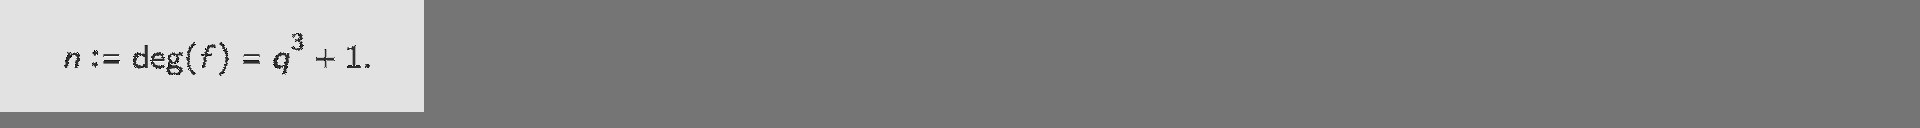

None

Predicted formula:
 <S> { \sf q } _ { 0 } { \bf f } _ { 7 } { \bf Z } _ { \bf 7 } } { \bf f } _ { \bf 7 } } { \bf f } _ { \bf j } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [12]:
### ALB
my_image_path= "Jupyter_Notebooks/test_photos/my_image.png"
#my_image = Image.open(my_image_path).convert("L") 

my_image = cv2.imread(my_image_path)
my_image =  cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_image= cv2.bitwise_not(my_image)
#my_image = PIL.ImageOps.invert(my_image)

my_image_tensor = dataset.image_transform_test(image=np.array(my_image))['image'][:1]
print(display(transform(my_image_tensor)))

print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))


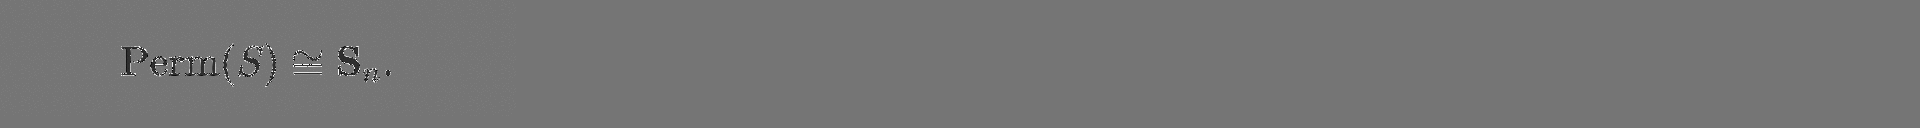

None

Predicted formula:
 <S> { \bf \Omega } { \bf \Omega } { \bf Z } { \bf f } { \bf \Omega } { \bf Z } } { \bf f } { \bf \Omega } { \bf Z } } { \bf I } } { \bf { \Omega } } } { \bf { q } } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [13]:
### ALB

my_image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
#my_image = Image.open(my_image_path).convert("L") 
my_image = cv2.imread(my_image_path)
my_image =  cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_image= cv2.bitwise_not(my_image)
#my_image = PIL.ImageOps.invert(my_image)

my_image_tensor = dataset.image_transform_test(image=np.array(my_image))['image'][:1]
print(display(transform(my_image_tensor)))

print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [14]:
### ALB

my_image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
my_image = Image.open(my_image_path).convert("L") 
my_image_tensor = dataset.image_transform_test(image=np.array(my_image))['image']
print(display(my_image))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

/home/resisistancerow_909/anaconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1414: UserWarning: The image is already gray.
  warnings.warn("The image is already gray.")


ValueError: operands could not be broadcast together with shapes (152,1920) (3,) (152,1920) 

In [ ]:
### ALB

my_image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
my_image = Image.open(my_image_path).convert("L") 
my_image_tensor = dataset.image_transform_test(image=np.array(my_image))['image']
print(display(my_image))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
### ALB

my_image_path= "Jupyter_Notebooks/test_photos/screenshot_2.png"
my_image = Image.open(my_image_path).convert("L") 
my_image_tensor = dataset.image_transform_test(image=np.array(my_image))['image']
print(display(my_image))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
# DISREGARD this uses wrong transformations

# Get image and label from train data -- change number for different ones
image_tensor, label = dataset.data_train[12]
transform = transforms.ToPILImage()
image = transform(image_tensor)

print('\nOriginal image and formula:')
display(image)
print(token_to_strings(label))
print('\nPredicted formula: \n')
with torch.no_grad():
    model.eval()
    prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(prediction),'\n')
print(display(Math(token_to_strings(prediction))))